In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
import warnings
from statsmodels.tsa.arima_model import ARIMA
warnings.filterwarnings("ignore") 

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

In [2]:
# Читаем файл с данными
df = pd.read_csv('my_PJME_MW.csv', index_col=[0, 1])

In [3]:
# Задаем индекс
df.index = pd.to_datetime(df.index.get_level_values('Date') + ' ' + df.index.get_level_values('Time'))

In [4]:
# Смотрим данные
df.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
2002-01-01 01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01 02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01 03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01 04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01 05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [5]:
# Делаем ресемпл по месяцам, суммируя значения показателя 'PJME_MW' за месяц
df_month = pd.DataFrame(df['PJME_MW'].resample('M').sum().values, 
                        columns=['PJME_MW'], 
                        index=df['PJME_MW'].resample('M').sum().index)

In [6]:
# Делаем ресемпл по месяцам, вычисляя среднее значение показателя 'PJME_MW' за месяц
df_month_mean = pd.DataFrame(df['PJME_MW'].resample('M').mean().values, 
                        columns=['PJME_MW'], 
                        index=df['PJME_MW'].resample('M').mean().index)

То, что получилось

In [7]:
df_month.head()

,PJME_MW
2002-01-31,23089022.0
2002-02-28,20320720.0
2002-03-31,21483191.0
2002-04-30,20516472.0
2002-05-31,20886798.0


In [8]:
df_month_mean.head()

,PJME_MW
2002-01-31,31075.399731
2002-02-28,30239.166667
2002-03-31,28875.256720
2002-04-30,28534.731572
2002-05-31,28073.653226


2. Подберите параметры модели SARIMAX для этого ряда.

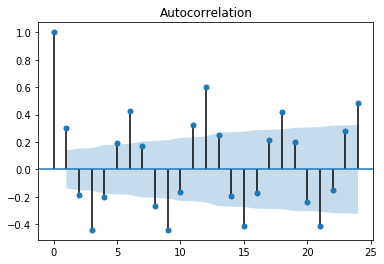

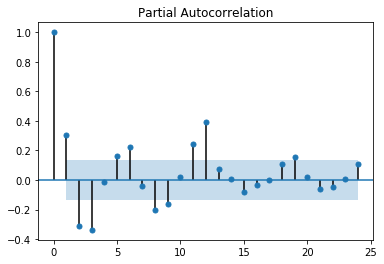

In [9]:
# Построим графики автокореляции и частичной автокорреляции, для выявления зависимостей между значениями
# и определения сезонности (суммарное значение показателя 'PJME_MW' по месяцам)
sm.graphics.tsa.plot_acf(df_month['PJME_MW'].values, lags=24)
plt.show()

sm.graphics.tsa.plot_pacf(df_month['PJME_MW'].values, lags=24)
plt.show()

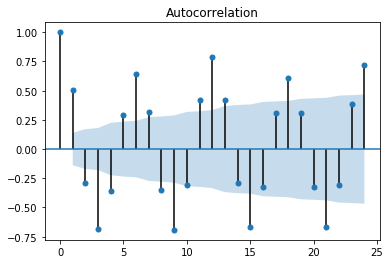

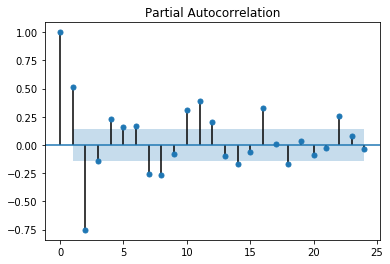

In [10]:
# Построим графики автокореляции и частичной автокорреляции, для выявления зависимостей между значениями
# и определения сезонности (среднее значение показателя 'PJME_MW' по месяцам)
sm.graphics.tsa.plot_acf(df_month_mean['PJME_MW'].values, lags=24)
plt.show()

sm.graphics.tsa.plot_pacf(df_month_mean['PJME_MW'].values, lags=24)
plt.show()

In [11]:
# Попробуем подобрать параметры на основе наших графиков
q = 1
p = 1
d = 1
pdq = [p, d, q]
qs = 1
ps = 1
ds = 0
seson = 12
seasonal_pdq = [ps, ds, qs, seson] 

In [12]:
# Построим модель
mod = sm.tsa.statespace.SARIMAX(df_month['PJME_MW'].values[:-12],order=pdq,
                                seasonal_order=seasonal_pdq ,
                                enforce_stationarity= False ,
                                enforce_invertibility=False)
results = mod.fit()

In [13]:
print(results.summary().tables[0],results.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  188
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -2738.767
Date:                            Wed, 13 May 2020   AIC                           5487.534
Time:                                    12:47:32   BIC                           5503.300
Sample:                                         0   HQIC                          5493.930
                                            - 188                                         
Covariance Type:                              opg                                         
========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

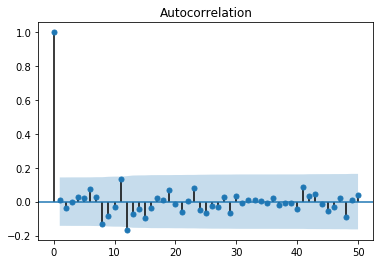

In [14]:
sm.graphics.tsa.plot_acf(results.resid, lags=50)
plt.show()

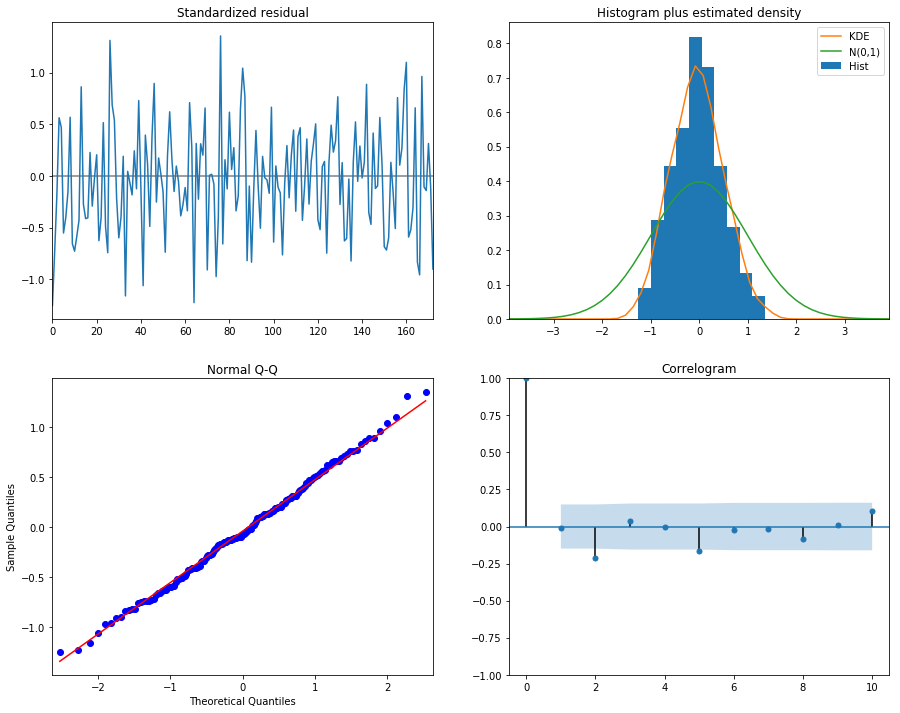

In [15]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [16]:
# Осуществим подбор параметров, методом перебора
# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# зададим сезонность p, q и q

p = [1, 2] 
d = [0,1]
q = range(0, 3)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [18]:
# Осуществляем перебор параметров
warnings.filterwarnings("ignore") # отключает предупреждения
res = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_month['PJME_MW'].values[100:-12],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = mod.fit()
            res.append([param, param_seasonal, results.aic])
        except:
            continue
df_res = pd.DataFrame(res)
res = df_res.loc[df_res[2] < (round(df_res[2].min(), -1) + 20)]
res

,0,1,2
107,"(0, 2, 2)","(2, 1, 2, 12)",1480.190194
215,"(1, 2, 2)","(2, 1, 2, 12)",1480.541079
310,"(2, 2, 1)","(2, 1, 1, 12)",1499.297352
323,"(2, 2, 2)","(2, 1, 2, 12)",1480.134812


In [17]:
# Построим модель на основе подобранных параметров
q = 2
p = 2
d = 2
pdq = [p, d, q]
qs = 2
ps = 1
ds = 2
seson = 12
seasonal_pdq = [ps, ds, qs, seson] 

In [18]:
mod = sm.tsa.statespace.SARIMAX(df_month['PJME_MW'].values[:-12],order=pdq,
                                seasonal_order=seasonal_pdq ,
                                enforce_stationarity= False ,
                                enforce_invertibility=False)
results = mod.fit()

In [19]:
print(results.summary().tables[0],results.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  188
Model:             SARIMAX(2, 2, 2)x(1, 2, 2, 12)   Log Likelihood               -2151.657
Date:                            Wed, 13 May 2020   AIC                           4319.315
Time:                                    12:48:05   BIC                           4342.557
Sample:                                         0   HQIC                          4328.760
                                            - 188                                         
Covariance Type:                              opg                                         
========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

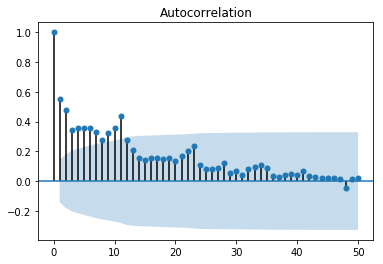

In [20]:
sm.graphics.tsa.plot_acf(results.resid, lags=50)
plt.show()

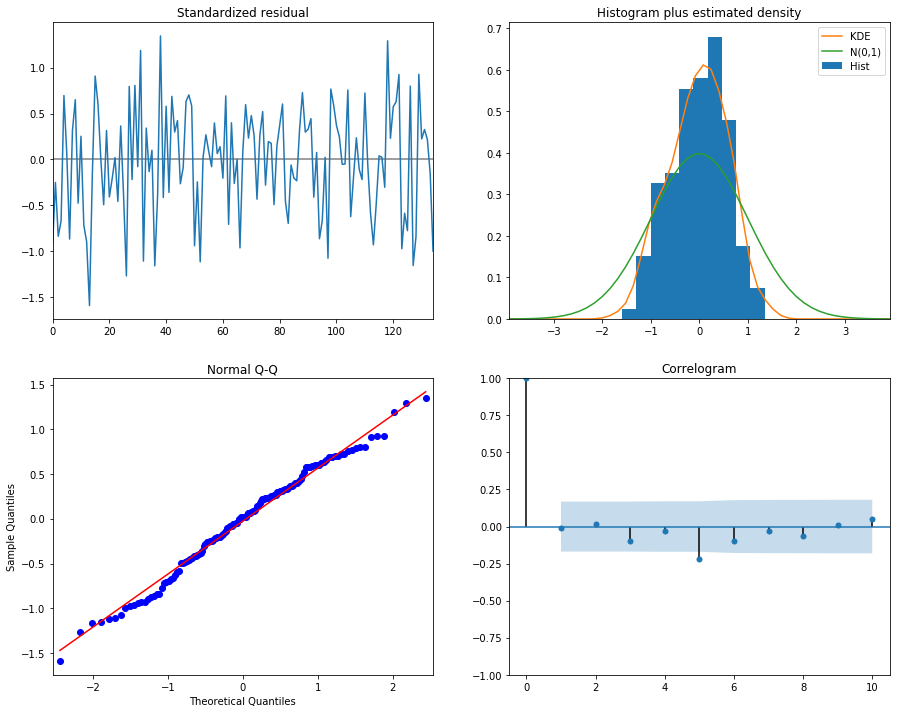

In [21]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

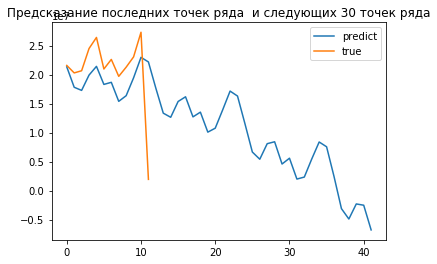

In [24]:
pred_dynamic = results.forecast(42)
# pred_dynamic_opt = results_opt.forecast(42)

plt.plot(pred_dynamic, label='predict' )
# plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(df_month['PJME_MW'].values[-12:],label='true')
plt.title('Предсказание последних точек ряда  и следующих 30 точек ряда')
plt.legend()

plt.show()

In [25]:
# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# зададим сезонность p, q и q

p = [2] 
d = [0,1]
q = range(0, 3)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [25]:
# Подберем параметры
warnings.filterwarnings("ignore")
res = []
i = 0
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            i = i + 1
            mod = sm.tsa.statespace.SARIMAX(df_month_mean['PJME_MW'].values[100:-12],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = mod.fit()
            res.append([param, param_seasonal, results.aic])
        except:
            continue
df_res = pd.DataFrame(res)
res = df_res.loc[df_res[2] == df_res[2].min()]
res

,0,1,2
53,"(0, 2, 2)","(2, 1, 2, 12)",854.229529


In [29]:
res = df_res.loc[df_res[2] < df_res[2].min() + 20]
res

,0,1,2
35,"(0, 1, 2)","(2, 1, 2, 12)",861.786584
53,"(0, 2, 2)","(2, 1, 2, 12)",854.229529
89,"(1, 1, 2)","(2, 1, 2, 12)",865.211763
101,"(1, 2, 1)","(2, 1, 2, 12)",872.038602
107,"(1, 2, 2)","(2, 1, 2, 12)",861.650054
143,"(2, 1, 2)","(2, 1, 2, 12)",860.741728
153,"(2, 2, 1)","(2, 1, 0, 12)",873.772567
154,"(2, 2, 1)","(2, 1, 1, 12)",869.730500
155,"(2, 2, 1)","(2, 1, 2, 12)",868.722491
161,"(2, 2, 2)","(2, 1, 2, 12)",855.108281


In [30]:
q = 2
p = 2
d = 2
pdq = [p, d, q]
qs = 2
ps = 1
ds = 2
seson = 12
seasonal_pdq = [ps, ds, qs, seson] 

In [31]:
mod = sm.tsa.statespace.SARIMAX(df_month_mean['PJME_MW'].values[:-12],order=pdq,
                                seasonal_order=seasonal_pdq ,
                                enforce_stationarity= False ,
                                enforce_invertibility=False)
results = mod.fit()
print('SARIMAX{}x{} - AIC:{}'.format(pdq, seasonal_pdq, results.aic))

SARIMAX[2, 2, 2]x[1, 2, 2, 12] - AIC:2485.638636488907


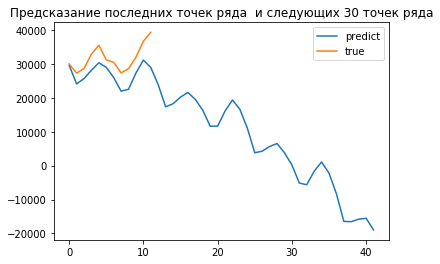

In [33]:
pred_dynamic = results.forecast(42)    #делаем предсказание на 3 точки от текущего конца ряда

plt.plot(pred_dynamic, label='predict' )
#Отобразим истинный значения 
plt.plot(df_month_mean['PJME_MW'].values[-12:],label='true')
plt.title('Предсказание последних точек ряда  и следующих 30 точек ряда')
plt.legend()

plt.show()

3. Сделайте вывод о том, как изменилась модель по сравнению с недельной.

Месячная модель получилась более точная, это произошло из-за того, что мы вычисляя среднее значение за месяц меньше обращаем внимание на отклонения в течении месяца.

4. Возмите вариант 1 или 2

    Вариант 1) - Постройте ACF, PACF и модель ARIMA для BRENT (недельный ресемплинг)
    
    Вариант 2) - Постройте ACF, PACF и модель ARIMA для СOVID_19 (по любой стране кроме Китая на дневных графиках ) https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset covid_19_data.csv тут можно скачать актуальные данные.

In [2]:
# Прочитаем файл с данными
df_COVID19 = pd.read_csv('covid_19_new.csv', index_col=[0])

In [3]:
# Преобразования
df_COVID19_rus = df_COVID19.loc[df_COVID19['Country/Region'] == 'Russia',
                                {'ObservationDate', 'Confirmed', 'Deaths', 'Recovered'}]
df_COVID19_rus.index = pd.to_datetime(df_COVID19_rus['ObservationDate'])
df_COVID19_rus.drop(columns='ObservationDate', inplace=True)
df_COVID19_rus.head()

,Confirmed,Deaths,Recovered
ObservationDate,,,
2020-01-31,2.0,0.0,0.0
2020-02-01,2.0,0.0,0.0
2020-02-02,2.0,0.0,0.0
2020-02-03,2.0,0.0,0.0
2020-02-04,2.0,0.0,0.0


In [4]:
df_COVID19_rus.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 101 entries, 2020-01-31 to 2020-05-10
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Confirmed  101 non-null    float64
 1   Deaths     101 non-null    float64
 2   Recovered  101 non-null    float64
dtypes: float64(3)
memory usage: 3.2 KB


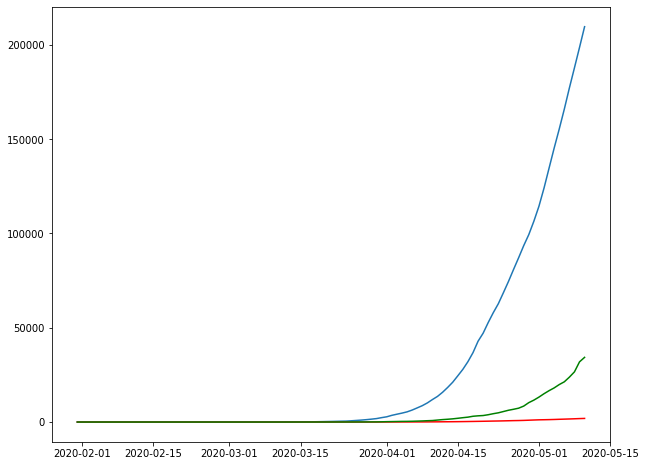

In [5]:
# Посмотрим наши показатели на графике
plt.figure(figsize=(10, 8))
plt.plot(df_COVID19_rus.index, df_COVID19_rus['Confirmed'])
plt.plot(df_COVID19_rus.index, df_COVID19_rus['Deaths'], 'r')
plt.plot(df_COVID19_rus.index, df_COVID19_rus['Recovered'], 'g')

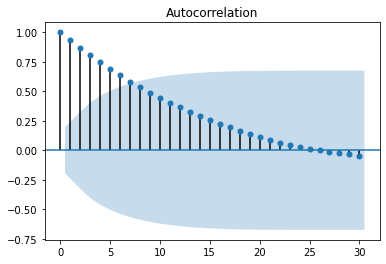

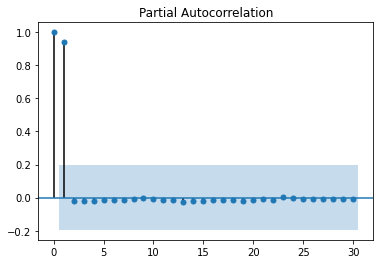

In [6]:
# Построим графики автокореляции и частичной автокорреляции, для выявления зависимостей между значениями
sm.graphics.tsa.plot_acf(df_COVID19_rus['Confirmed'].values, lags=30)
plt.show()

sm.graphics.tsa.plot_pacf(df_COVID19_rus['Confirmed'].values, lags=30)
plt.show()

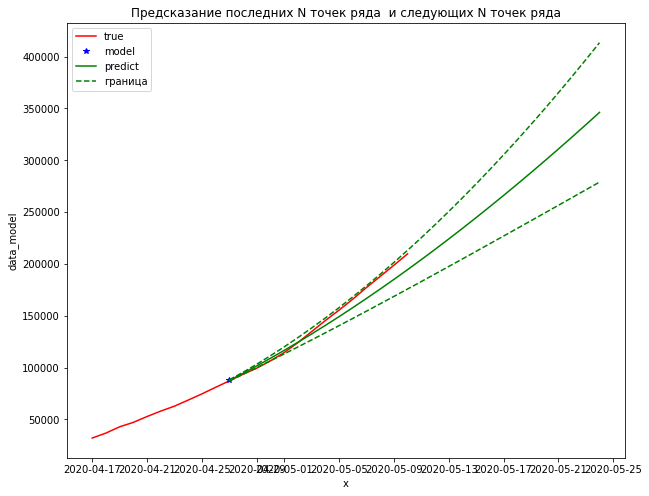

In [154]:
# Построим модель и отобразим на графике полученные результаты
p = 5
d = 2
q = 1
n = 14
ln = len(df_COVID19_rus[:-n])
model = ARIMA(df_COVID19_rus['Confirmed'][:-n], order=(p, d, q))
model_fit = model.fit(disp=False)
y_p = model_fit.predict(len(df_COVID19_rus['Confirmed'][:-n]), 
                        len(df_COVID19_rus['Confirmed'][:-n]),
                        typ='levels')
y_f = model_fit.forecast(n*2)
# Даты предсказаний
date_pred = pd.date_range('2020-04-27', '2020-05-24')
# Построим график результатов предсказания
plt.figure(figsize=(10, 8))
plt.plot(df_COVID19_rus['Confirmed'][-10-n:], 'r', label ='true')
plt.plot(y_p, '*b', label ='model')
plt.plot(date_pred, y_f[0], 'g', label ='predict')
plt.plot(date_pred, y_f[2][:, 1], '--g', label = 'граница')
plt.plot(date_pred, y_f[2][:, 0], '--g')
plt.xlabel('x')
plt.ylabel('data_model')
plt.title('Предсказание последних N точек ряда  и следующих N точек ряда')
plt.legend()
plt.show()

5. Оцените результат моделирования

Из графика видно, что истенные значения находятся в рамках доверительного интервала, следовательно модель и ее доверительный интервал достаточно хорошо описывают количество зараженных за сутки.